## Load and Preprocess Data for VAE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('../data/raw/sp500.csv', index_col='Date', parse_dates=True)

# Convert columns to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Focus on 'Close' price
close_prices = data['Close']

# Compute log returns
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Reshape and normalize
log_returns_array = log_returns.values.reshape(-1, 1)

# Normalize between 0 and 1
scaler = MinMaxScaler()
log_returns_scaled = scaler.fit_transform(log_returns_array)

print(f"Shape of normalized data: {log_returns_scaled.shape}")


Shape of normalized data: (6036, 1)


## Build the Variational Autoencoder (VAE) Model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Parameters
latent_dim = 8

# Encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

inputs = layers.Input(shape=(1,))
h = layers.Dense(32, activation='relu')(inputs)
h = layers.Dense(16, activation='relu')(h)
z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
z = Sampling()([z_mean, z_log_var])

# Decoder
decoder_h1 = layers.Dense(16, activation='relu')
decoder_h2 = layers.Dense(32, activation='relu')
decoder_output = layers.Dense(1, activation='sigmoid')

h_decoded = decoder_h1(z)
h_decoded = decoder_h2(h_decoded)
outputs = decoder_output(h_decoded)

# Full VAE model
class VAE(Model):
    def __init__(self, encoder_inputs, encoder_outputs, decoder_outputs, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        self.decoder = Model(z, decoder_outputs, name="decoder")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = reconstruction_loss_fn(data, reconstruction)
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

vae = VAE(inputs, outputs, outputs)
vae.compile(optimizer='adam')

print("VAE model is ready (subclassed model version).")


VAE model is ready (subclassed model version).


## Train the VAE Model

In [6]:
history = vae.fit(
    log_returns_scaled,  # Normalized log returns
    epochs=300,
    batch_size=128,
    shuffle=True
)

print("VAE training completed!")

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 6.7307e-04 - loss: 0.0086 - reconstruction_loss: 0.0080
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 1.2761e-05 - loss: 0.0034 - reconstruction_loss: 0.0033
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 8.0413e-06 - loss: 0.0031 - reconstruction_loss: 0.0031
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 7.6407e-06 - loss: 0.0030 - reconstruction_loss: 0.0030
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - kl_loss: 7.0467e-06 - loss: 0.0030 - reconstruction_loss: 0.0030
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 6.0515e-06 - loss: 0.0029 - reconstruction_loss: 0.0029
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 5.2078e-06 - loss: 0.0029 - reconstruction_loss: 0.0029
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 4.3398e-06 - loss: 0.0029 - reconstruction_loss: 0.0029
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_

> ### Save the Trained VAE Model


In [7]:
vae.save('../models/vae_model.h5')

print("VAE model saved.")


VAE model saved.


## Generate Synthetic Data with VAE

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


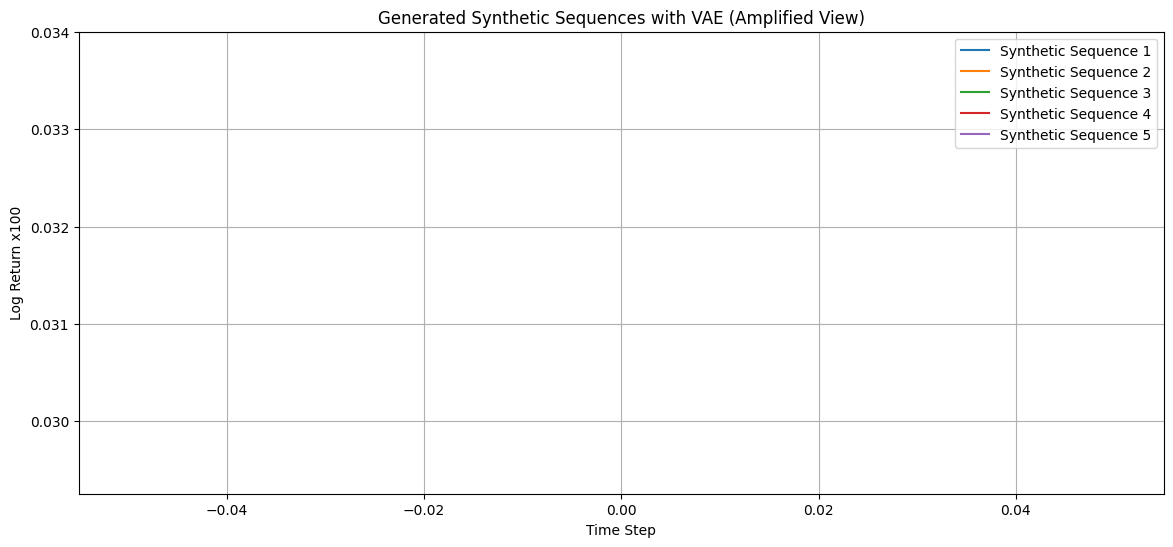

In [9]:
n_samples = 100
latent_samples = np.random.normal(size=(n_samples, latent_dim))

# Generate sequences by decoding the latent samples
synthetic_sequences = vae.decoder.predict(latent_samples)

# Rescale back to original log-return scale
synthetic_sequences_rescaled = scaler.inverse_transform(synthetic_sequences)

# Plot a few synthetic sequences (with amplification for better visualization)
plt.figure(figsize=(14,6))

for i in range(5):
    plt.plot(synthetic_sequences_rescaled[i] * 100, label=f'Synthetic Sequence {i+1}')  # Amplify x100 for visibility

plt.title('Generated Synthetic Sequences with VAE (Amplified View)')
plt.xlabel('Time Step')
plt.ylabel('Log Return x100')
plt.legend()
plt.grid(True)
plt.show()
